# Poisoning Attacks

---

## 1. Backdoor Attack

**API Reference:**
- https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/poisoning.html#backdoor-poisoning-attack

**Related paper:**
- https://arxiv.org/abs/1708.06733


Posion the training dataset by inserting a backdoor image.

---

In [16]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution() # To use the ART

from tensorflow.keras import datasets, layers, models

from art.utils import load_dataset
from art.estimators.classification import KerasClassifier

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

cifar_model_path = '/archive/workspace/TTA/demo/models/baisc_cnn_cifar'

### Load dadaset (CIFAR10)

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str("cifar10"))
x_val, y_val = x_train[40000:], y_train[40000:]
x_train, y_train = x_train[:40000], y_train[:40000]

class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'ship', 'truck']

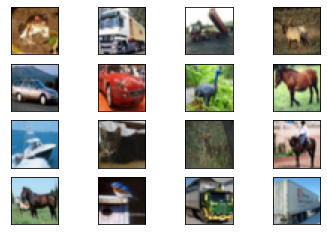

In [4]:
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)

### Load pre-trained model

In [4]:
trained_model = models.load_model(cifar_model_path)
classifier = KerasClassifier(model=trained_model, clip_values=(0, 1))

2021-12-20 16:53:44.648087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 16:53:44.648627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 16:53:44.652411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 16:53:44.652939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 16:53:44.653435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [30]:
loss_test, accuracy_test = trained_model.evaluate(x_test, y_test)
print('Accuracy on test data(Before attack): {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data(Before attack): 79.50%


### Generate adversairal examples

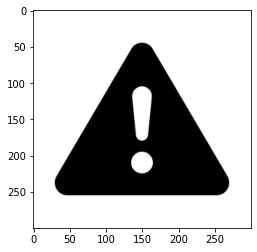

In [22]:
backdoo_img='images/backdoors/alert.png'
backdoor = mpimg.imread(backdoo_img)
plt.imshow(backdoor)

In [28]:
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image

num_sample = 20

attack_bd = PoisoningAttackBackdoor(lambda x: insert_image(x, 
                                                           backdoor_path=backdoo_img,
                                                           size=(10,10),
                                                           mode='RGB',
                                                          ))

poisoned_x, poisoned_y = attack_bd.poison(x_train[:num_sample], y_train[:num_sample])

In [26]:
loss_test, accuracy_test = trained_model.evaluate(poisoned_x, y_test[:num_sample])
perturbation = np.mean(np.abs((poisoned_x - x_test[:num_sample])))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 10.00%
Average perturbation: 0.27


Text(0.5, 1.0, 'adversarial img')

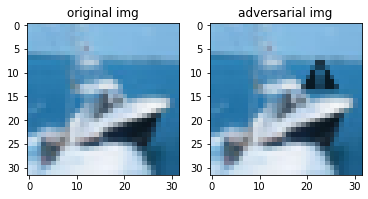

In [41]:
plt.subplot(1, 2, 1)
plt.imshow(x_train[8])
plt.title('original img')
      
plt.subplot(1, 2, 2)
plt.imshow(poisoned_x[8])
plt.title('adversarial img')

---

## 2. Clean Label Feature Collision Attack

**API Reference:**
- https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/poisoning.html#clean-label-backdoor-attack

**Related paper:**
- https://arxiv.org/abs/1804.00792


### Adversary's goal: make some easy money 

The goal of the adversary is add a backdoor at test time, and turn any digit to a 9. Unlike other backdoor poisoning methods, it will only poison a small percentage of points **in the target class**.

This poisoning method is effective because before the trigger is added, a PGD perturbation is added to the image based on a classifier the attacker trains separately. This makes the image difficult for the neural net to interpret, leaving only the backdoor trigger to use for classification.

---

In [5]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.compat.v1.disable_eager_execution() # To use the ART
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import FeatureCollisionAttack


cifar_model_path = '/archive/workspace/TTA/demo/models/baisc_cnn_cifar'

### Load dataset (CIFAR-10)

In [6]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')

num_samples_train = 1000
num_samples_test = 1000
x_train = x_train[0:num_samples_train]
y_train = y_train[0:num_samples_train]
x_test = x_test[0:num_samples_test]
y_test = y_test[0:num_samples_test]

class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

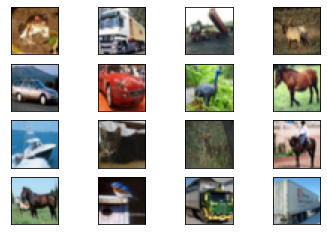

In [7]:
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)

### Load pre-trained model 

In [8]:
path = get_file('cifar_alexnet.h5',extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/ta75pl4krya5djj/cifar_alexnet.h5?dl=1')
classifier_model = load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False, 
                             preprocessing=(0.5, 1))

Instructions for updating:
Colocations handled automatically by placer.


2021-12-21 13:27:51.818241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 13:27:51.818811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 13:27:51.822100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 13:27:51.822927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 13:27:51.823396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [13]:
loss_test, accuracy_test = classifier_model.evaluate(x_test, y_test)
print('Accuracy on test data(Before attack): {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data(Before attack): 83.00%


true_class: bird
predicted_class: bird


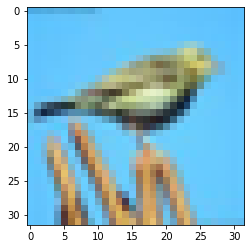

In [14]:
target_class = "bird" # one of ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
target_label = np.zeros(len(class_descr))
target_label[class_descr.index(target_class)] = 1
target_instance = np.expand_dims(x_test[np.argmax(y_test, axis=1) == class_descr.index(target_class)][3], axis=0)

fig = plt.imshow(target_instance[0])

print('true_class: ' + target_class)
print('predicted_class: ' + class_descr[np.argmax(classifier.predict(target_instance), axis=1)[0]])

feature_layer = classifier.layer_names[-2]

### Generate poison sample

In [24]:
base_class = "frog" # one of ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
base_idxs = np.argmax(y_test, axis=1) == class_descr.index(base_class)
base_instances = np.copy(x_test[base_idxs][:10])
base_labels = y_test[base_idxs][:10]

x_test_pred = np.argmax(classifier.predict(base_instances), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(base_labels, axis=1))

print("New test data to be poisoned (10 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(10-nb_correct_pred))

New test data to be poisoned (10 images):
Correctly classified: 9
Incorrectly classified: 1


predicted label (true label):


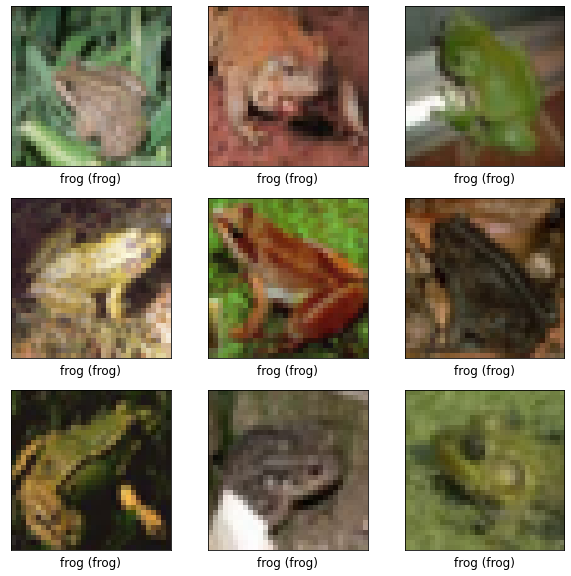

In [25]:
print('predicted label (true label):' )

plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_pred[i]], class_descr[np.argmax(base_labels[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(base_instances[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

In [26]:
attack = FeatureCollisionAttack(classifier, target_instance, feature_layer, max_iter=10, similarity_coeff=256, watermark=0.3)
poison, poison_labels = attack.poison(base_instances)

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

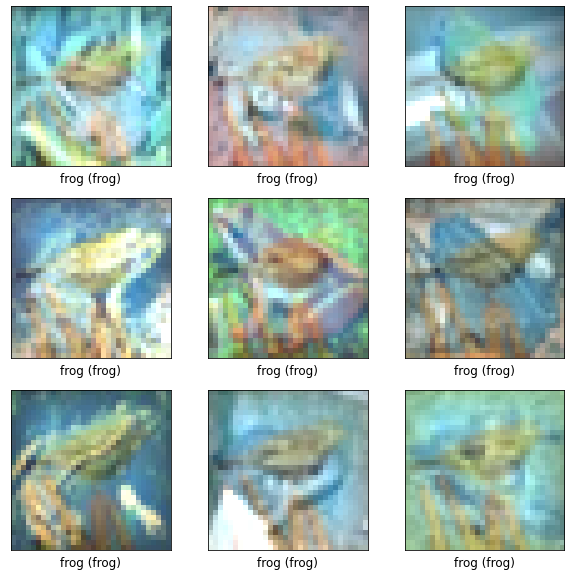

In [28]:
poison_pred = np.argmax(classifier.predict(poison), axis=1)
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[poison_pred[i]], class_descr[np.argmax(poison_labels[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(poison[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

### Train the model with Poison Images

In [ ]:
# classifier.set_learning_phase(True)
print(x_train.shape)
print(base_instances.shape)
adv_train = np.vstack([x_train, poison])
adv_labels = np.vstack([y_train, poison_labels])
classifier.fit(adv_train, adv_labels, nb_epochs=10, batch_size=4)

true_class: bird
predicted_class: bird


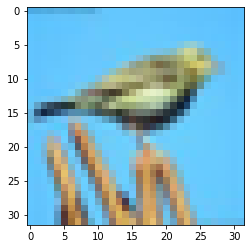

In [30]:
fig = plt.imshow(target_instance[0])

print('true_class: ' + target_class)
print('predicted_class: ' + class_descr[np.argmax(classifier.predict(target_instance), axis=1)[0]])